In [91]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Conv2D,Input,LeakyReLU,Flatten,Reshape,Conv2DTranspose,Activation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
#####Load Dataset
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
yy = df['label'].to_numpy()
yy = yy.astype('int32')
data = df.drop(['label'],axis=1)
data = data.to_numpy()
data = data.astype('float32')/255.0
data = data.reshape(-1,28,28,1)
xx = data

In [94]:
data.shape

(42000, 28, 28, 1)

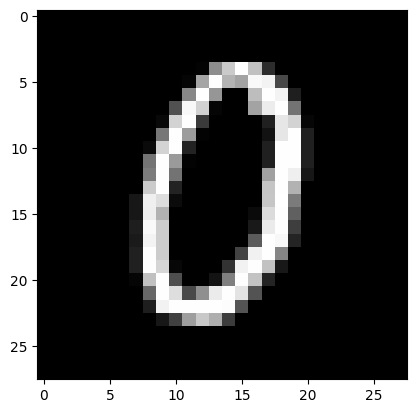

In [95]:
plt.imshow(data[5].reshape(28,28),cmap='gray')

In [96]:
#####Encoder
encoder_input = Input(shape=(28,28,1),name='encoder_input')
encoder_conv_0 = Conv2D(filters=32,kernel_size=3,strides=1,padding='same')(encoder_input)
encoder_conv_0 = LeakyReLU()(encoder_conv_0)
encoder_conv_1 = Conv2D(filters=64,kernel_size=3,strides=2,padding='same')(encoder_conv_0)
encoder_conv_1 = LeakyReLU()(encoder_conv_1)
encoder_conv_2 = Conv2D(filters=64,kernel_size=3,strides=2,padding='same')(encoder_conv_1)
encoder_conv_2 = LeakyReLU()(encoder_conv_2)
encoder_conv_3 = Conv2D(filters=64,kernel_size=3,strides=1,padding='same')(encoder_conv_2)
encoder_conv_3 = LeakyReLU()(encoder_conv_3)
shape_before_flattening = keras.backend.int_shape(encoder_conv_3)[1:]
encoder_flattened = Flatten()(encoder_conv_3)
encoder_output = Dense(2,name='encoder_output')(encoder_flattened)
encoder = keras.models.Model(encoder_input,encoder_output)

In [97]:
encoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 7, 7, 64)          0  

In [98]:
####Decoder
decoder_input =  Input(shape=(2,),name='decoder_input')
decoder_dense = Dense(np.prod(shape_before_flattening))(decoder_input)
decoder_reshape = Reshape(shape_before_flattening)(decoder_dense)
decoder_conv_t_0 = Conv2DTranspose(filters=64,kernel_size=3,strides=1,padding='same',name='decoder_conv_t_0')(decoder_reshape)
decoder_conv_t_0 = LeakyReLU()(decoder_conv_t_0)
decoder_conv_t_1 = Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',name='decoder_conv_t_1')(decoder_conv_t_0)
decoder_conv_t_1 = LeakyReLU()(decoder_conv_t_1)
decoder_conv_t_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='decoder_conv_t_2')(decoder_conv_t_1)
decoder_conv_t_2 = LeakyReLU()(decoder_conv_t_2)
decoder_conv_t_3 = Conv2DTranspose(filters=1,kernel_size=3,strides=1,padding='same',name='decoder_conv_t_3')(decoder_conv_t_2)
decoder_output = Activation('sigmoid')(decoder_conv_t_3)
decoder = keras.models.Model(decoder_input,decoder_output)

In [99]:
decoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                  

In [100]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = keras.models.Model(model_input,model_output)

In [101]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 7, 7, 64)          0  

In [102]:
optimizer_ = keras.optimizers.Adam()

In [103]:
def r_loss(y_true,y_pred):
    return keras.backend.mean(keras.backend.square(y_true-y_pred),axis=[1,2,3])

In [104]:
model.compile(optimizer=optimizer_,loss=r_loss)

In [105]:
X_train = data

In [106]:
history = model.fit(x=X_train,y=X_train,batch_size=64,shuffle=True,epochs=25)

Epoch 1/25
657/657 [==============================] - 11s 13ms/step - loss: 0.0596
Epoch 2/25
657/657 [==============================] - 8s 13ms/step - loss: 0.0479
Epoch 3/25
657/657 [==============================] - 9s 13ms/step - loss: 0.0453
Epoch 4/25
657/657 [==============================] - 9s 14ms/step - loss: 0.0440
Epoch 5/25
657/657 [==============================] - 9s 14ms/step - loss: 0.0431
Epoch 6/25
657/657 [==============================] - 9s 14ms/step - loss: 0.0425
Epoch 7/25
657/657 [==============================] - 10s 15ms/step - loss: 0.0420
Epoch 8/25
657/657 [==============================] - 10s 15ms/step - loss: 0.0416
Epoch 9/25
657/657 [==============================] - 14s 21ms/step - loss: 0.0413
Epoch 10/25
657/657 [==============================] - 16s 25ms/step - loss: 0.0410
Epoch 11/25
657/657 [==============================] - 13s 20ms/step - loss: 0.0408
Epoch 12/25
657/657 [==============================] - 13s 19ms/step - loss: 0.0406
Epoch 

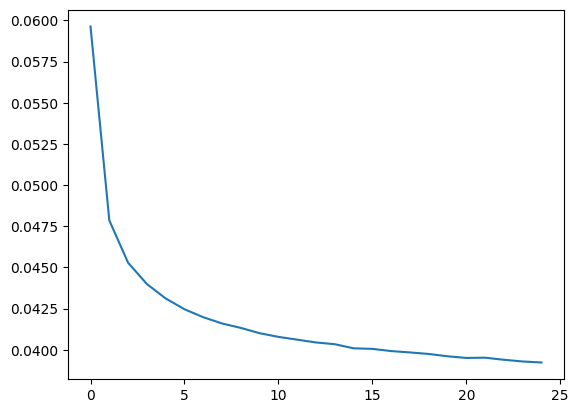

In [107]:
plt.plot(history.history['loss'])

In [108]:
#############LATENT SPACE VISUALIZATION

In [109]:
numbers = df['label'].to_numpy().astype('int32')
xx = df.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1).astype('float32')/255.0

In [110]:
predictions = encoder.predict(xx)

1313/1313 [==============================] - 9s 7ms/step


<AxesSubplot: >

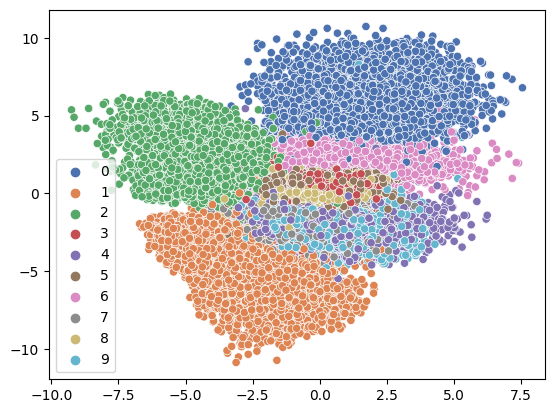

In [111]:
sns.scatterplot(x=predictions[:,0],y=predictions[:,1],hue=numbers,palette="deep")

In [112]:
#####GENERATING EXAMPLES

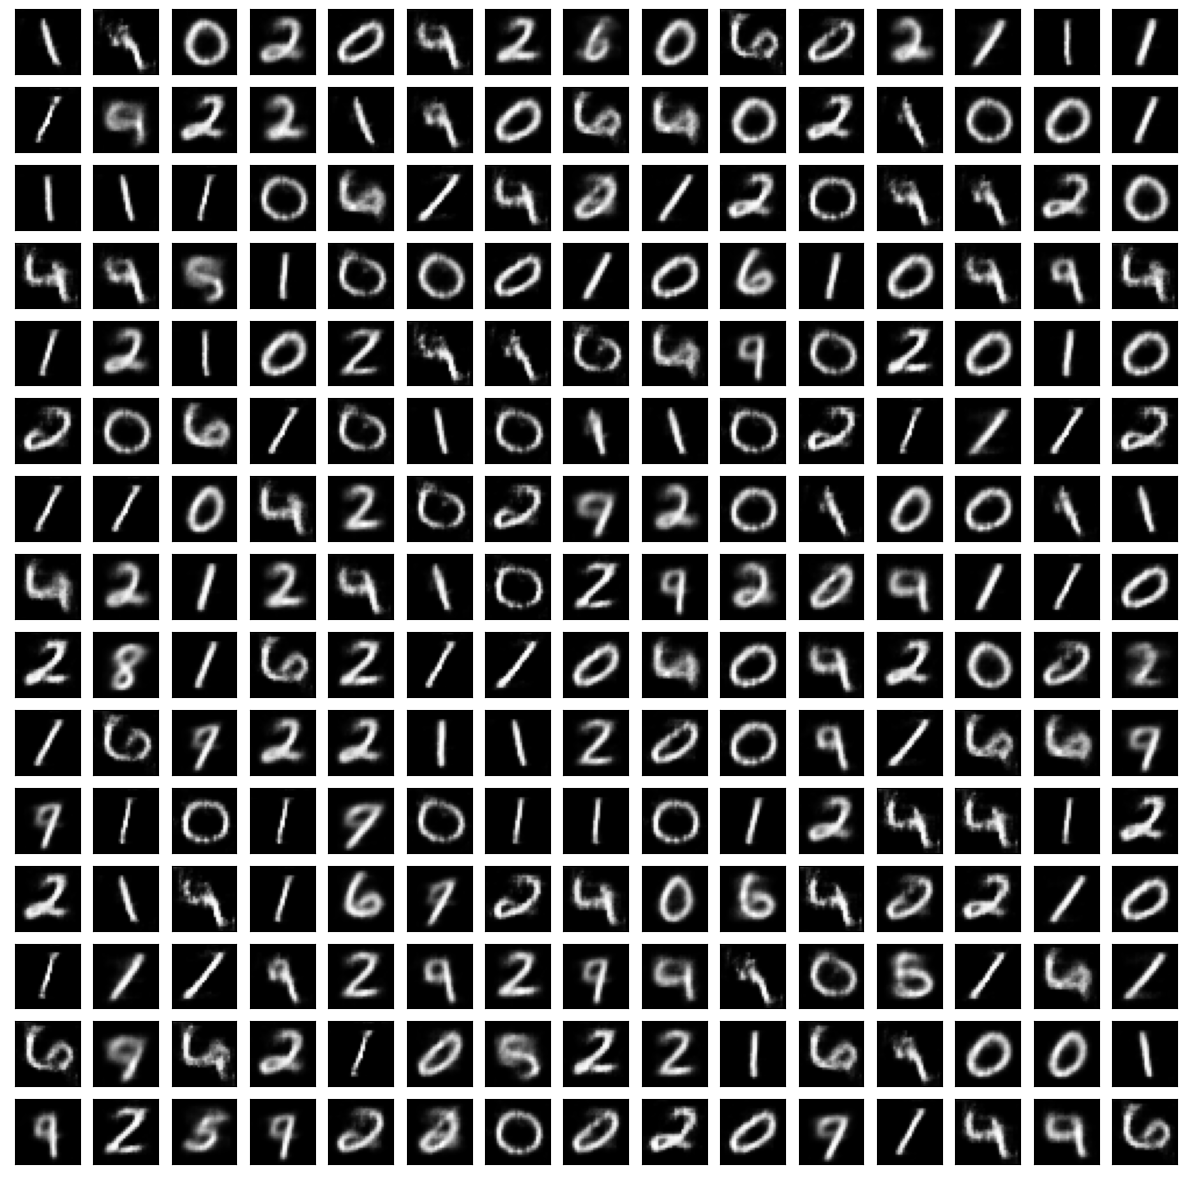

In [131]:
fig,ax = plt.subplots(15,15)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(0,15):
    for j in range(0,15):
        x = np.random.uniform(-10,10)
        y = np.random.uniform(-10,10)
        pred = decoder.predict([[x,y]],verbose=0)
        ax[i,j].imshow(pred.reshape(28,28),cmap='gray')
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
plt.show()